In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.simplefilter("ignore", UserWarning)

import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize

<Figure size 432x288 with 0 Axes>

# Data

In [2]:
x = np.arange(256)/256
frequency = np.random.normal(64,16,size=10*256)
slope = np.random.normal(0,10,size=frequency.size)
labels = np.stack([frequency,slope]).T
data = np.sin(x[None,:]*frequency[:,None]) + slope[:,None]*x[None,:]  + np.random.rand(x.size*frequency.size).reshape(-1,x.size)

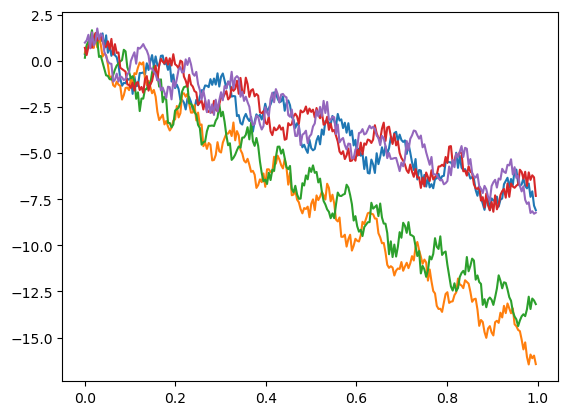

In [3]:
for i in range(5):
    plt.plot(x,data[i])

In [4]:
train_len = int(.8*len(labels))
train_labels = torch.tensor(labels[:train_len],dtype=torch.float32).reshape(-1,32,labels.shape[-1])
train_data = torch.tensor(data[:train_len],dtype=torch.float32).reshape(-1,32,data.shape[-1])

test_labels = torch.tensor(labels[train_len:],dtype=torch.float32).reshape(-1,32,labels.shape[-1])
test_data = torch.tensor(data[train_len:],dtype=torch.float32).reshape(-1,32,data.shape[-1])

In [5]:
data_mean = train_data.mean()
data_std = train_data.std()

def z_transform(data_batch):
    return (data_batch - data_batch.mean(-1).unsqueeze(-1))/data_std

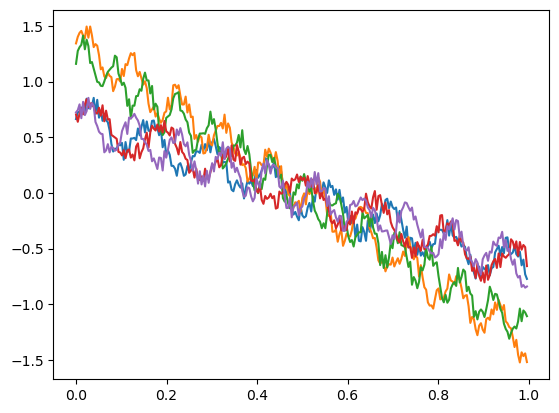

In [6]:
for i in range(5):
    plt.plot(x,z_transform(torch.tensor(data[i],dtype=torch.float32)))

# Controllable SNPE_C

In [7]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from typing import Any, Callable, Dict, Optional, Union
from sbi.inference.snpe import snpe_base
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi import utils as sbi_utils
from torch.distributions import Distribution, MultivariateNormal, Uniform
from pyknos.mdn.mdn import MultivariateGaussianMDN as mdn


class Neural_Density_Estimator(SNPE_C):

    def __init__(self, embedding_net, embedding_size = 8,
                 prior_low = (1.8,0.6),prior_high = (3.4,1.8),
                 flow_model = 'maf', flow_hidden_features = 100, flow_num_transforms = 10, device = None):

        if device is None:
            use_cuda = torch.cuda.is_available()
            device = 'cuda' if use_cuda else 'cpu'
        self.device = device

        prior = sbi_utils.BoxUniform(low=torch.tensor(prior_low, device=self.device),
                                     high=torch.tensor(prior_high, device=self.device), device=self.device)

        embedding_net.to(self.device)

        # 'z_score_x' has to be none. You control normalization of the data that you pass to your embedding network
        neural_posterior = sbi_utils.posterior_nn(model=flow_model,hidden_features=flow_hidden_features,
                                                  num_transforms=flow_num_transforms,z_score_x='none',
                                                  embedding_net=embedding_net)

        super(Neural_Density_Estimator, self).__init__ (prior=prior, density_estimator=neural_posterior, device=self.device)


    def _init_network(self,
                      train_theta, batch_x):
        """z_score_x should be 'none' in neural posterior estimator"""

        #dummy_x = torch.zeros((train_theta.shape[0],*x_shape),dtype=torch.float32,device=train_theta.device)

        # Use only training data for building the neural net (z-scoring transforms)
        self._neural_net = self._build_neural_net(
            train_theta.to("cpu"),
            batch_x.to("cpu"),
        )
        self._x_shape = sbi_utils.x_shape_from_simulation(batch_x.to("cpu"))

        sbi_utils.test_posterior_net_for_multi_d_x(
            self._neural_net,
            train_theta.to("cpu"),
            batch_x.to("cpu"),
        )

        self._neural_net.to(self._device)


    def _prepare_SNPE_C_for_training(
        self,
        train_theta, batch_x,
        num_atoms: int = 10,
        calibration_kernel: Optional[Callable] = None,
        force_first_round_loss: bool = False,
        use_combined_loss: bool = False):
        r"""Return density estimator that approximates the distribution $p(\theta|x)$.
        Args:
            num_atoms: Number of atoms to use for classification.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
            use_combined_loss: Whether to train the neural net also on prior samples
                using maximum likelihood in addition to training it on all samples using
                atomic loss. The extra MLE loss helps prevent density leaking with
                bounded priors.
        Returns:
            proposal,calibration_kernel
        """

        # WARNING: sneaky trick ahead. We proxy the parent's `train` here,
        # requiring the signature to have `num_atoms`, save it for use below, and
        # continue. It's sneaky because we are using the object (self) as a namespace
        # to pass arguments between functions, and that's implicit state management.
        self._num_atoms = num_atoms
        self._use_combined_loss = use_combined_loss
        kwargs = sbi_utils.del_entries(
            locals(), entries=("self", "__class__", "num_atoms", "use_combined_loss")
        )

        # We have no proposal so
        self._proposal_roundwise.append(None)
        self._data_round_index.append(0)
        self._round = max(self._data_round_index)


        if self._round > 0:
            # Set the proposal to the last proposal that was passed by the user. For
            # atomic SNPE, it does not matter what the proposal is. For non-atomic
            # SNPE, we only use the latest data that was passed, i.e. the one from the
            # last proposal.
            proposal = self._proposal_roundwise[-1]
            self.use_non_atomic_loss = (
                isinstance(proposal.posterior_estimator._distribution, mdn)
                and isinstance(self._neural_net._distribution, mdn)
                and sbi_utils.check_dist_class(
                    self._prior, class_to_check=(Uniform, MultivariateNormal)
                )[0]
            )

            algorithm = "non-atomic" if self.use_non_atomic_loss else "atomic"
            print(f"Using SNPE-C with {algorithm} loss")

            if self.use_non_atomic_loss:
                # Take care of z-scoring, pre-compute and store prior terms.
                self._set_state_for_mog_proposal()

        return self._prepare_Posterior_estimator_for_training(train_theta, batch_x,calibration_kernel,force_first_round_loss)

    def _prepare_Posterior_estimator_for_training(
        self,
        train_theta, batch_x,
        calibration_kernel: Optional[Callable] = None,
        force_first_round_loss: bool = False,
    ):
        r"""Initializes stuff for training.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
        Returns:
            proposal,calibration_kernel
        """
        # Load data from most recent round.
        self._round = max(self._data_round_index)

        if self._round == 0 and self._neural_net is not None:
            assert force_first_round_loss, (
                "You have already trained this neural network. After you had trained "
                "the network, you again appended simulations with `append_simulations"
                "(theta, x)`, but you did not provide a proposal. If the new "
                "simulations are sampled from the prior, you can set "
                "`.train(..., force_first_round_loss=True`). However, if the new "
                "simulations were not sampled from the prior, you should pass the "
                "proposal, i.e. `append_simulations(theta, x, proposal)`. If "
                "your samples are not sampled from the prior and you do not pass a "
                "proposal and you set `force_first_round_loss=True`, the result of "
                "SNPE will not be the true posterior. Instead, it will be the proposal "
                "posterior, which (usually) is more narrow than the true posterior."
            )

        # Calibration kernels proposed in Lueckmann, Gonçalves et al., 2017.
        if calibration_kernel is None:
            calibration_kernel = lambda x: torch.ones([len(x)], device=self._device)

        # Set the proposal to the last proposal that was passed by the user. For
        # atomic SNPE, it does not matter what the proposal is. For non-atomic
        # SNPE, we only use the latest data that was passed, i.e. the one from the
        # last proposal.
        proposal = self._proposal_roundwise[-1]

        self._init_network(train_theta, batch_x)
        neural_network = self._neural_net

        return neural_network, proposal,calibration_kernel

# Convolutional embedding_net

In [11]:
def conv_bn_relu(in_dim, out_dim,width_stride=2):
    return nn.Sequential(
        nn.Conv1d(in_dim, out_dim, 3, width_stride, 1,bias=False),
        nn.BatchNorm1d(out_dim),
        nn.ReLU())

class Embedding_net(nn.Module):

    def __init__(self,in_dim = 256,out_dim = 8):
        super(Embedding_net,self).__init__()

        self.grid_conv = nn.Sequential(
            conv_bn_relu(1, 16,width_stride=2),
            conv_bn_relu(16, 16,width_stride=2),
            nn.MaxPool1d(2,2),
            conv_bn_relu(16, 32,width_stride=2),
            conv_bn_relu(32, 32,width_stride=2),
            nn.MaxPool1d(2,2)
        )

        self.linear = nn.Linear(32*int(in_dim//64),out_dim)

    def forward(self, x):

        x = x.unsqueeze(1)

        for layer in self.grid_conv:
            x =layer(x)

        x = self.linear(x.view(x.shape[0],-1))
        return x

# Networks

## Initialize nets

In [12]:
def _init_weights(m):
    if isinstance(m, torch.nn.Linear):
        #torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
        #torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
        #torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)

In [13]:
embedding_net = Embedding_net()
_ = embedding_net.apply(_init_weights)

inference = Neural_Density_Estimator(embedding_net,prior_low = train_labels.view(-1,2).min(0).values,
                                     prior_high = train_labels.view(-1,2).max(0).values,flow_hidden_features = 60,flow_num_transforms = 3,device='cpu')

## Prepare internal SBI stuff

In [14]:
neural_network,proposal,calibration_kernel = inference._prepare_SNPE_C_for_training(train_labels.view(-1,train_labels.shape[-1]),train_data[0])
masks_batch = torch.ones((train_data.shape[1],1),dtype=torch.bool,device=inference._device)

# Train

In [15]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(
                list(inference._neural_net.parameters()), lr=learning_rate)

In [16]:
train_history = []
inference._neural_net.train()

for epoch in tqdm(range(1,500)):
    for i,(datum,label) in enumerate(zip(train_data,train_labels)):

        optimizer.zero_grad()

        normalized_datum = z_transform(datum)

        losses = inference._loss(
                        label,
                        normalized_datum,
                        masks_batch,
                        proposal,
                        calibration_kernel
            )

        loss = losses.mean()
        loss.backward()

        optimizer.step()

        train_history.append(loss.item())

    if epoch%100 == 0:
        print('Iter {} loss={:.4f}'.format(epoch,np.mean(train_history[-len(train_data):])))

 20%|██        | 100/499 [00:40<02:37,  2.54it/s]

Iter 100 loss=4.2298


 40%|████      | 200/499 [01:19<01:58,  2.53it/s]

Iter 200 loss=4.5755


 60%|██████    | 300/499 [02:02<01:20,  2.47it/s]

Iter 300 loss=4.2627


 80%|████████  | 400/499 [02:43<00:38,  2.56it/s]

Iter 400 loss=3.6606


100%|██████████| 499/499 [03:26<00:00,  2.41it/s]


# Test

In [18]:
_ = inference._neural_net.eval()

In [19]:
posterior = inference.build_posterior(inference._neural_net)

In [20]:
def get_samples(index):

    observation=z_transform(test_data.flatten(0,1)[index].unsqueeze(0))
    samples = posterior.sample((1000,), x=torch.tensor(observation,dtype=torch.float32, device=device))
    samples=samples.numpy()

    return samples

In [21]:
samples = get_samples(0)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

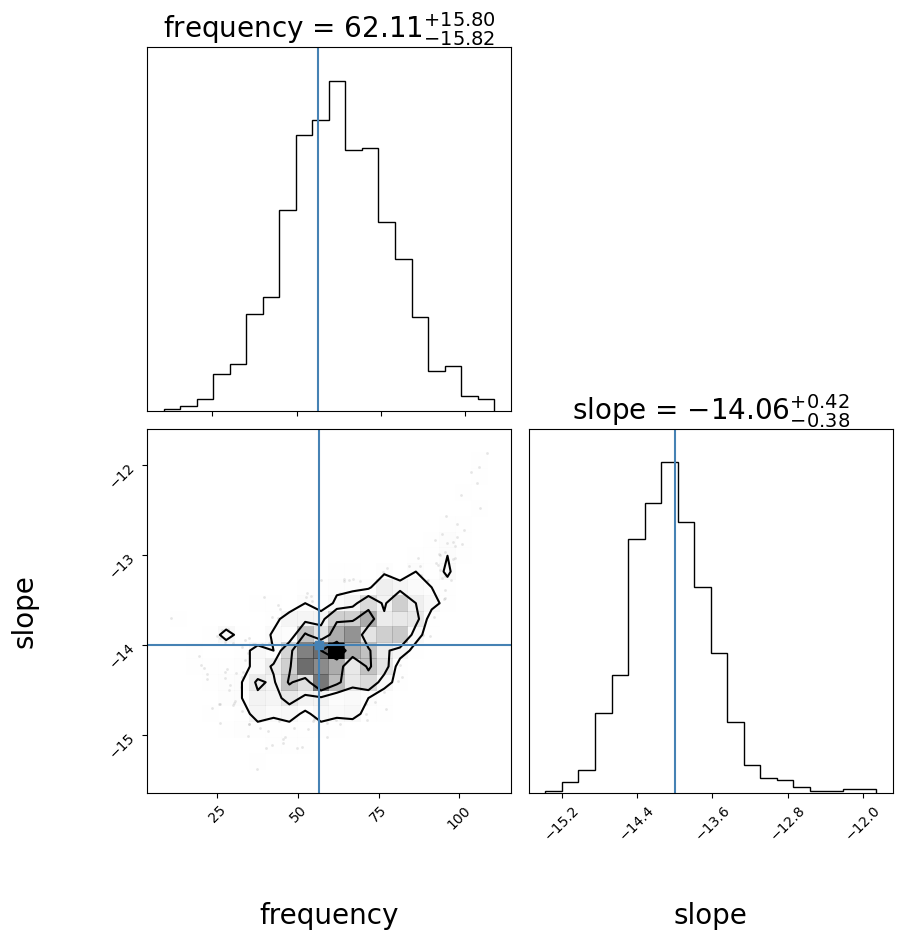

In [24]:
import corner

fig = plt.figure(figsize=(10, 10))
fig=corner.corner(samples,fig=fig,show_titles=True,labels=['frequency','slope'],
          title_kwargs={'fontsize':20}, label_kwargs={'fontsize': 20},truths=test_labels.flatten(0,1)[0])
plt.show()

In [25]:
!pwd

/Users/egorssed/Desktop/Science/sbi-lensed-qso/Neural_Networks/Gaussian_process_inference/Neural_Density_Estimator
